In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from transformers import BertTokenizer, BertModel
import torch
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [79]:
data = pd.read_csv('../BindDBdata/DrugBankDTI/final_drug_target_db.csv')
data.rename(columns={'SMILES':'smiles', 'Target Sequence':'sequence'}, inplace=True)
data.head()

,DrugBank ID,Drug Name,smiles,Target Name,sequence,UniProt ID,Gene Name
0,DB00006,Bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,Prothrombin,MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANT...,P00734,F2
1,DB00007,Leuprolide,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,Gonadotropin-releasing hormone receptor,MANSASPEQNQNHCSAINNSIPLMQGNLPTLTLSGKIRVTVTFFLF...,P30968,GNRHR
2,DB00014,Goserelin,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,Lutropin-choriogonadotropic hormone receptor,MKQRFSALQLLKLLLLLQPPLPRALREALCPEPCNCVPDGALRCPG...,P22888,LHCGR
3,DB00014,Goserelin,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,Gonadotropin-releasing hormone receptor,MANSASPEQNQNHCSAINNSIPLMQGNLPTLTLSGKIRVTVTFFLF...,P30968,GNRHR
4,DB00035,Desmopressin,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,Vasopressin V2 receptor,MLMASTTSAVPGHPSLPSLPSNSSQERPLDTRDPLLARAELALLSI...,P30518,AVPR2


In [4]:
data.head(1000).to_csv('../BindDBdata/DrugBankDTI/final_drug_target_db_GPT.csv', index=False)

In [6]:
# Function to generate negative pairs
def generate_negative_pairs(df, negative_positive_ratio=1):
    # Extract unique drugs and targets
    unique_drugs = df['DrugBank ID'].unique()
    unique_targets = df['Target Name'].unique()
    
    # Create a set of positive pairs for quick lookup
    positive_pairs = set(zip(df['DrugBank ID'], df['Target Name']))
    
    # Calculate the number of negative pairs needed
    num_positive_pairs = len(df)
    num_negative_pairs = int(num_positive_pairs * negative_positive_ratio)
    
    # Generate negative pairs
    negative_pairs = set()
    while len(negative_pairs) < num_negative_pairs:
        drug = random.choice(unique_drugs)
        target = random.choice(unique_targets)
        if (drug, target) not in positive_pairs and (drug, target) not in negative_pairs:
            negative_pairs.add((drug, target))
    
    # Create a DataFrame for negative pairs
    negative_df = pd.DataFrame(list(negative_pairs), columns=['DrugBank ID', 'Target Name'])
    return negative_df

In [7]:
# Generate negative pairs with a 1:1 ratio
negative_df = generate_negative_pairs(data, negative_positive_ratio=1)

# Merge negative pairs with original dataframe to retain required columns
negative_df = negative_df.merge(data[['DrugBank ID', 'Drug Name', 'smiles']].drop_duplicates(),
                                on='DrugBank ID', how='left')
negative_df = negative_df.merge(data[['Target Name', 'sequence', 'UniProt ID', 'Gene Name']].drop_duplicates(),
                                on='Target Name', how='left')

# Rearrange columns for clarity
negative_df = negative_df[['DrugBank ID', 'Drug Name', 'smiles', 
                           'Target Name', 'sequence', 'UniProt ID', 'Gene Name']]

In [8]:
# Add labels to positive (1) and negative (0) dataframes
positive_df = data.copy()
positive_df['label'] = 1

negative_df['label'] = 0

In [9]:
# Combine positive and negative datasets
combined_df = pd.concat([positive_df, negative_df], ignore_index=True)

{'Total Samples': 37081, 'Train Samples': 25956, 'Validation Samples': 5562, 'Test Samples': 5563}


In [82]:
torch.save(combined_df, '../BindDBdata/DrugBankDTI/final_drug_target_db.pt')

In [80]:
combined_df.sample(10)

,DrugBank ID,Drug Name,smiles,Target Name,sequence,UniProt ID,Gene Name,label,drug_features,protein_features
35603,DB07903,"3-[(2,2-DIMETHYLPROPANOYL)AMINO]-N-1,3-THIAZOL...",CC(C)(C)C(=O)NC1=C(N=CC=C1)C(=O)NC1=NC=CS1,Allantoate amidohydrolase,MITHFRQAIEETLPWLSSFGADPAGGMTRLLYSPEWLETQQQFKKR...,P77425,allC,0,"[0.39774364, 0.16646378, -0.074604, -0.2855421...","[-0.07416138, -0.063402176, -0.03511643, 0.286..."
26879,DB12329,Eravacycline,[H][C@@]12CC3=C(F)C=C(NC(=O)CN4CCCC4)C(O)=C3C(...,Beta-lactamase (KPC-2),MSLYRRLVLLSCLSWPLAGFSATALTNLVAEPFAKLEQDFGGSIGV...,Q93LQ9,KPC-2,0,"[0.28879344, 0.107401915, -0.2804799, -0.05837...","[-0.099800564, -0.08669068, 0.27791163, 0.0552..."
14642,DB08908,Dimethyl fumarate,[H]\C(=C(\[H])C(=O)OC)C(=O)OC,Kelch-like ECH-associated protein 1,MQPDPRPSGAGACCRFLPLQSQCPEGAGDAVMYASTECKAEVTPSQ...,Q14145,KEAP1,1,"[0.71718353, 0.40617216, 0.29100633, 0.1236107...","[0.000790417, -0.06568375, 0.06560895, -0.0033..."
30440,DB06883,1-[1-(3-aminophenyl)-3-tert-butyl-1H-pyrazol-5...,CC(C)(C)C1=NN(C(NC(=O)NC2=CC=CC=C2)=C1)C1=CC=C...,Serine/threonine-protein kinase N1,MASDAVQSEPRSWSLLEQLGLAGADLAAPGVQQQLELERERLRREI...,Q16512,PKN1,0,"[0.62157303, 0.39104518, 0.016839266, -0.51660...","[-0.093084484, -0.21503492, 0.09978649, 0.0038..."
26526,DB08738,1-{3-oxo-3-[(2S)-2-(pyrrolidin-1-ylcarbonyl)py...,[H][C@]1(CCCN1C(=O)CCN1C(=O)C(=NC2=CC=CC=C12)C...,Stabilin-2,MMLQHLVIFCLGLVVQNFCSPAETTGQARRCDRKSLLTIRTECRSC...,Q8WWQ8,STAB2,0,"[0.43650657, 0.35244972, -0.24489158, 0.095446...","[-0.022553517, -0.020935953, 0.057421613, -0.0..."
35678,DB07434,HONH-BENZYLMALONYL-L-ALANYLGLYCINE-P-NITROANILIDE,[H][C@@](C)(NC(=O)[C@]([H])(CC1=CC=CC=C1)C(=O)...,mRNA interferase EndoA,MIVKRGDVYFADLSPVVGSEQGGVRPVLVIQNDIGNRFSPTAIVAA...,P96622,ndoA,0,"[0.13450634, 0.20206943, -0.4767132, -0.228264...","[-0.049823865, -0.057521995, 0.15899943, 0.045..."
18823,DB01088,Iloprost,[H][C@]12C[C@@H](O)[C@H](\C=C\[C@@H](O)C(C)CC#...,L-cysteine:1D-myo-inositol 2-amino-2-deoxy-alp...,MQSWYCPPVPVLPGRGPQLRLYDSADRQVRPVAPGSKATMYVCGIT...,A5U4F6,mshC,0,"[0.42273644, 0.36299193, -0.03958371, -0.35985...","[0.035661057, -0.07206886, -0.03273112, -0.105..."
10431,DB04531,S-Benzylcysteine,N[C@@H](CSCC1=CC=CC=C1)C(O)=O,Methylated-DNA--protein-cysteine methyltransfe...,MDKDCEMKRTTLDSPLGKLELSGCEQGLHEIKLLGKGTSAADAVEV...,P16455,MGMT,1,"[0.13803285, 0.36207867, 0.28893504, -0.486571...","[-0.036444098, -0.27822673, 0.1419626, 0.10960..."
10923,DB04910,Oxibendazole,CCCOC1=CC2=C(C=C1)N=C(NC(=O)OC)N2,Tubulin beta-4B chain,MREIVHLQAGQCGNQIGAKFWEVISDEHGIDPTGTYHGDSDLQLER...,P68371,TUBB4B,1,"[0.44109598, 0.60822463, 0.0638337, -0.1887651...","[0.08463077, 0.009521286, 0.061969843, 0.09580..."
31338,DB15498,BOS172722,CCOC1=CC(=CC=C1NC1=NC=C2C=C(C)N=C(NCC(C)(C)C)C...,Modification methylase TaqI,MGLPPLLSLPSNSAPRSLGRVETPPEVVDFMVSLAEAPRGGRVLEP...,P14385,taqIM,0,"[0.4879669, 0.35883385, 0.018228656, -0.161589...","[-0.14710985, -0.1955307, 0.07114893, 0.332723..."


In [46]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load ChemRoBERTa tokenizer and model
chem_tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chem_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Load ESM2 tokenizer and model
esm_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

python(37144) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
from transformers import AutoTokenizer, AutoModel

esm_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t33_650M_UR50D")
print(esm_model.config.hidden_size)  # Should output 768


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1280


In [47]:
def extract_chem_features(smiles):
    """Extract ChemRoBERTa features from SMILES."""
    try:
        tokens = chem_tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embeddings = chem_model(**tokens).last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings
    except:
        return np.zeros(768)  # Return zero vector if extraction fails

def extract_esm_features(sequence):
    """Extract ESM2 features from protein sequence."""
    try:
        tokens = esm_tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embeddings = esm_model(**tokens).last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings
    except:
        return np.zeros(320)  # Return zero vector if extraction fails

In [48]:
print(esm_model.config.hidden_size)  # Should output 768


320


In [49]:
# Function to featurize drug SMILES into molecular fingerprints
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    else:
        return np.zeros(2048)

# Load ProtBERT for protein embedding
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")
model = BertModel.from_pretrained("Rostlab/prot_bert")

# Function to featurize protein sequences
def featurize_protein(sequence):
    inputs = tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

python(37279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [50]:
# Featurize drugs
# Extract unique drugs and proteins
unique_drugs = combined_df[['smiles']].drop_duplicates()
unique_proteins = combined_df[['sequence']].drop_duplicates()


In [51]:
len(unique_drugs)

7037

In [52]:
len(unique_proteins)

4488

In [19]:
# Extract features for unique drugs
tqdm.pandas()  # Enable progress bar for pandas
unique_drugs['drug_features'] = unique_drugs['smiles'].progress_apply(extract_chem_features)

100%|██████████| 7037/7037 [02:44<00:00, 42.78it/s]


In [20]:
# Extract features for unique proteins
unique_proteins['protein_features'] = unique_proteins['sequence'].progress_apply(extract_esm_features)

100%|██████████| 4488/4488 [38:49<00:00,  1.93it/s]     


In [42]:
test_protein = unique_proteins.head(10)
test_protein['protein_features'] = test_protein['sequence'].progress_apply(featurize_protein)

(320,)

In [21]:
# Merge features back into the combined dataframe
combined_df = combined_df.merge(unique_drugs, on='smiles', how='left')
combined_df = combined_df.merge(unique_proteins, on='sequence', how='left')

In [3]:
combined_df = torch.load('../BindDBdata/DrugBankDTI/final_drug_target_db.pt')
combined_df.head(10)

/var/folders/7_/j8_cym2s23jfxbknz2gsv_h80000gn/T/ipykernel_7824/64994438.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_df = torch.load('../BindDBdata/DrugBank

,DrugBank ID,Drug Name,smiles,Target Name,sequence,UniProt ID,Gene Name,label,drug_features,protein_features
0,DB00006,Bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,Prothrombin,MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANT...,P00734,F2,1,"[0.12367651, -0.11629033, -0.32446206, -0.1863...","[0.032777727, -0.16312091, 0.25423577, 0.02565..."
1,DB00007,Leuprolide,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,Gonadotropin-releasing hormone receptor,MANSASPEQNQNHCSAINNSIPLMQGNLPTLTLSGKIRVTVTFFLF...,P30968,GNRHR,1,"[0.30849046, 0.15551889, -0.28953308, -0.46136...","[-0.09399643, 0.09683378, 0.28784642, 0.362544..."
2,DB00014,Goserelin,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,Lutropin-choriogonadotropic hormone receptor,MKQRFSALQLLKLLLLLQPPLPRALREALCPEPCNCVPDGALRCPG...,P22888,LHCGR,1,"[0.2731691, 0.120439306, -0.30485785, -0.49663...","[-0.12336816, 0.0052934284, 0.12210869, 0.2243..."
3,DB00014,Goserelin,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,Gonadotropin-releasing hormone receptor,MANSASPEQNQNHCSAINNSIPLMQGNLPTLTLSGKIRVTVTFFLF...,P30968,GNRHR,1,"[0.2731691, 0.120439306, -0.30485785, -0.49663...","[-0.09399643, 0.09683378, 0.28784642, 0.362544..."
4,DB00035,Desmopressin,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,Vasopressin V2 receptor,MLMASTTSAVPGHPSLPSLPSNSSQERPLDTRDPLLARAELALLSI...,P30518,AVPR2,1,"[0.15777779, 0.019015854, -0.61661655, -0.2766...","[-0.15067358, 0.058883306, 0.122039355, 0.3116..."
5,DB00035,Desmopressin,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,Vasopressin V1a receptor,MRLSAGPDAGPSGNSSPWWPLATGAGNTSREAEALGEGNGPPRDVR...,P37288,AVPR1A,1,"[0.15777779, 0.019015854, -0.61661655, -0.2766...","[-0.09531109, 0.014099074, 0.1844407, 0.356780..."
6,DB00035,Desmopressin,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,Vasopressin V1b receptor,MDSGPLWDANPTPRGTLSAPNATTPWLGRDEELAKVEIGVLATVLV...,P47901,AVPR1B,1,"[0.15777779, 0.019015854, -0.61661655, -0.2766...","[-0.08122913, -0.05596988, 0.14349571, 0.30986..."
7,DB00050,Cetrorelix,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,Gonadotropin-releasing hormone receptor,MANSASPEQNQNHCSAINNSIPLMQGNLPTLTLSGKIRVTVTFFLF...,P30968,GNRHR,1,"[0.12538147, 0.023606855, -0.2818439, -0.51492...","[-0.09399643, 0.09683378, 0.28784642, 0.362544..."
8,DB00050,Cetrorelix,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,Lutropin-choriogonadotropic hormone receptor,MKQRFSALQLLKLLLLLQPPLPRALREALCPEPCNCVPDGALRCPG...,P22888,LHCGR,1,"[0.12538147, 0.023606855, -0.2818439, -0.51492...","[-0.12336816, 0.0052934284, 0.12210869, 0.2243..."
9,DB00067,Vasopressin,NCCCCC(NC(=O)C1CCCN1C(=O)C1CSSCC(N)C(=O)NC(CC2...,Vasopressin V2 receptor,MLMASTTSAVPGHPSLPSLPSNSSQERPLDTRDPLLARAELALLSI...,P30518,AVPR2,1,"[0.20821181, -0.36930653, -0.6589119, -0.01796...","[-0.15067358, 0.058883306, 0.122039355, 0.3116..."


In [5]:
# DataFrame to store AUCs

auc_history = pd.DataFrame(columns=['epoch', 'Train Loss', 'Train AUC', 'Val Loss', 'Val AUC'])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Define dataset
class DTI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'drug_features': torch.tensor(np.asarray(row['drug_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

# Define Diffusion Generative Model
class DiffusionGenerativeModel(nn.Module):
    def __init__(self, drug_input_dim, protein_input_dim, hidden_dim, num_timesteps):
        super(DiffusionGenerativeModel, self).__init__()
        self.num_timesteps = num_timesteps
        self.drug_encoder = nn.Linear(drug_input_dim, hidden_dim)
        self.protein_encoder = nn.Linear(protein_input_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.denoise_model = nn.Linear(hidden_dim * 2, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()

    def forward(self, drug_features, protein_features, t):
        # Encode drug and protein features
        drug_embedding = self.activation(self.drug_encoder(drug_features))
        protein_embedding = self.activation(self.protein_encoder(protein_features))

        # Concatenate embeddings
        combined = torch.cat((drug_embedding, protein_embedding), dim=-1)
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)

        # Add learnable timestep embedding
        t_embedding = nn.Embedding(self.num_timesteps, combined.size(1))(t.long())
        combined += t_embedding

        # Denoise process
        denoised = self.activation(self.denoise_model(combined))

        # Classification layer
        output = torch.sigmoid(self.classifier(denoised))
        return output

    def add_noise(self, x, noise_level=0.1):
        noise = noise_level * torch.randn_like(x)
        return x + noise

# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(combined_df, test_size=0.3, stratify=combined_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

train_dataset = DTI_Dataset(train_df)
val_dataset = DTI_Dataset(val_df)
test_dataset = DTI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Verify feature dimensions
for batch in train_loader:
    drug_input_dim = batch['drug_features'].shape[1]  # Dynamically determine drug input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
num_timesteps = 10
model = DiffusionGenerativeModel(drug_input_dim=drug_input_dim, protein_input_dim=protein_input_dim, hidden_dim=512, num_timesteps=num_timesteps)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
pos_weight = torch.tensor([len(train_df) / train_df['label'].sum() - 1], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Training and Validation Loop
for epoch in range(200):
    model.train()
    total_loss = 0
    val_total_loss = 0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        drug_features = batch['drug_features']
        protein_features = batch['protein_features']
        labels = batch['label']

        # Add noise to the features
        noisy_drug_features = model.add_noise(drug_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        optimizer.zero_grad()
        outputs = model(noisy_drug_features, noisy_protein_features, torch.randint(0, num_timesteps, (drug_features.size(0),))).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for AUC calculation
        train_predictions.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate AUC for training
    train_auc = roc_auc_score(train_labels, train_predictions)
    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1} - Train Loss: {total_loss / len(train_loader):.4f}, Train AUC: {train_auc:.4f}")

    # Validation AUC
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            drug_features = batch['drug_features']
            protein_features = batch['protein_features']
            labels = batch['label']

            # Add noise to the features
            noisy_drug_features = model.add_noise(drug_features, noise_level=0.1)
            noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

            outputs = model(noisy_drug_features, noisy_protein_features, torch.randint(0, num_timesteps, (drug_features.size(0),))).squeeze()
            val_predictions.extend(torch.sigmoid(outputs).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_auc = roc_auc_score(val_labels, val_predictions)
    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation AUC: {val_auc:.4f}")
    
     # Save AUC to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train AUC': train_auc, 'Val Loss': val_total_loss / len(val_loader), 'Val AUC': val_auc}
    auc_history = pd.concat([auc_history, pd.DataFrame([new_row])], ignore_index=True)

# Test AUC
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        drug_features = batch['drug_features']
        protein_features = batch['protein_features']
        labels = batch['label']

        # Add noise to the features
        noisy_drug_features = model.add_noise(drug_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        outputs = model(noisy_drug_features, noisy_protein_features, torch.randint(0, num_timesteps, (drug_features.size(0),))).squeeze()
        test_predictions.extend(torch.sigmoid(outputs).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_auc = roc_auc_score(test_labels, test_predictions)
print(f"Test AUC: {test_auc:.4f}")


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Test Evaluation with Additional Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        drug_features = batch['drug_features']
        protein_features = batch['protein_features']
        labels = batch['label']

        # Add noise to the features
        noisy_drug_features = model.add_noise(drug_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        outputs = model(noisy_drug_features, noisy_protein_features, torch.randint(0, num_timesteps, (drug_features.size(0),))).squeeze()
        test_predictions.extend(torch.sigmoid(outputs).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Convert predictions to binary
test_predictions_binary = (np.array(test_predictions) >= 0.5).astype(int)

# Calculate Metrics
test_auc = roc_auc_score(test_labels, test_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions_binary)
test_precision = precision_score(test_labels, test_predictions_binary, zero_division=0)
test_recall = recall_score(test_labels, test_predictions_binary, zero_division=0)
test_f1 = f1_score(test_labels, test_predictions_binary, zero_division=0)

# Sensitivity and Specificity
tn, fp, fn, tp = confusion_matrix(test_labels, test_predictions_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

# Print Results
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall (Sensitivity): {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test Specificity: {test_specificity:.4f}")

In [ ]:
# Initialize or append to metrics DataFrame
metrics_columns = ['Dataset', 'AUC', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'F1-Score']
test_metrics = {
    'Dataset': 'Test',
    'AUC': test_auc,
    'Accuracy': test_accuracy,
    'Sensitivity': test_sensitivity,
    'Specificity': test_specificity,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1-Score': test_f1
}

# Check if metrics_df exists; if not, initialize it
try:
    metrics_df
except NameError:
    metrics_df = pd.DataFrame(columns=metrics_columns)

# Append the test metrics to the DataFrame
metrics_df = pd.concat([metrics_df, pd.DataFrame([test_metrics])], ignore_index=True)

# # Save metrics_df to CSV for future reference
# metrics_df.to_csv("test_metrics_results.csv", index=False)

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Initialize DataFrame to store metrics
metrics_df = pd.DataFrame(columns=['Model', 'Dataset', 'AUC', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'F1-Score'])

def calculate_metrics(y_true, y_pred_proba, y_pred):
    """
    Calculate performance metrics.
    """
    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Sensitivity and Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    return auc, accuracy, sensitivity, specificity, precision, recall, f1

def evaluate_model(model_name, model, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Train and evaluate a model, and save metrics to DataFrame.
    """
    global metrics_df

    # Train predictions
    train_pred_proba = model.predict_proba(X_train)[:, 1]
    train_pred = (train_pred_proba >= 0.5).astype(int)
    train_metrics = calculate_metrics(y_train, train_pred_proba, train_pred)
    
    # Validation predictions
    val_pred_proba = model.predict_proba(X_val)[:, 1]
    val_pred = (val_pred_proba >= 0.5).astype(int)
    val_metrics = calculate_metrics(y_val, val_pred_proba, val_pred)

    # Test predictions
    test_pred_proba = model.predict_proba(X_test)[:, 1]
    test_pred = (test_pred_proba >= 0.5).astype(int)
    test_metrics = calculate_metrics(y_test, test_pred_proba, test_pred)

    # Append metrics to DataFrame
    datasets = ['Training', 'Validation', 'Test']
    metrics = [train_metrics, val_metrics, test_metrics]
    rows = []
    for dataset, metric in zip(datasets, metrics):
        auc, accuracy, sensitivity, specificity, precision, recall, f1 = metric
        rows.append({
            'Model': model_name,
            'Dataset': dataset,
            'AUC': auc,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
    
    # Update metrics_df
    metrics_df = pd.concat([metrics_df, pd.DataFrame(rows)], ignore_index=True)

# Load your data
# Assuming `combined_df` contains all necessary columns
# Split into train, validation, and test sets
train_df, temp_df = train_test_split(combined_df, test_size=0.3, stratify=combined_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

X_train = np.hstack((np.vstack(train_df['drug_features']), np.vstack(train_df['protein_features'])))
X_val = np.hstack((np.vstack(val_df['drug_features']), np.vstack(val_df['protein_features'])))
X_test = np.hstack((np.vstack(test_df['drug_features']), np.vstack(test_df['protein_features'])))
y_train, y_val, y_test = train_df['label'], val_df['label'], test_df['label']

# Scale features for certain models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
evaluate_model('Random Forest', rf_model, X_train, y_train, X_val, y_val, X_test, y_test)

# SVM
svm_model = SVC(probability=True, kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)
evaluate_model('SVM', svm_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

# GBM
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm_model.fit(X_train, y_train)
evaluate_model('GBM', gbm_model, X_train, y_train, X_val, y_val, X_test, y_test)

# Logistic Regression
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train_scaled, y_train)
evaluate_model('Logistic Regression', log_reg_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

# MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(512, 256), activation='relu', max_iter=200, random_state=42)
mlp_model.fit(X_train_scaled, y_train)
evaluate_model('MLP', mlp_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

# # Save metrics_df to CSV
# metrics_df.to_csv("model_comparison_metrics.csv", index=False)

/var/folders/7_/j8_cym2s23jfxbknz2gsv_h80000gn/T/ipykernel_7824/419528040.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame(rows)], ignore_index=True)
/Users/chengwang/anaconda3/envs/spavae/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [9]:
metrics_df

,Model,Dataset,AUC,Accuracy,Sensitivity,Specificity,Precision,Recall,F1-Score
0,Random Forest,Training,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Random Forest,Validation,0.907517,0.832255,0.766362,0.891275,0.863266,0.766362,0.811933
2,Random Forest,Test,0.912580,0.839295,0.766831,0.904226,0.877667,0.766831,0.818514
3,SVM,Training,0.944854,0.869548,0.839230,0.896713,0.879228,0.839230,0.858764
4,SVM,Validation,0.869780,0.793959,0.765601,0.819359,0.791503,0.765601,0.778337
5,SVM,Test,0.877604,0.799209,0.766831,0.828221,0.800000,0.766831,0.783065
6,GBM,Training,0.851301,0.767067,0.670308,0.853762,0.804186,0.670308,0.731169
7,GBM,Validation,0.806278,0.726897,0.624429,0.818678,0.755177,0.624429,0.683608
8,GBM,Test,0.816072,0.732518,0.629137,0.825153,0.763267,0.629137,0.689741
9,Logistic Regression,Training,0.795079,0.723648,0.677156,0.765303,0.721070,0.677156,0.698423


In [10]:
# Filter the DataFrame to include only test data
test_metrics_df = metrics_df[metrics_df['Dataset'] == 'Test']

# Reshape the DataFrame for plotting
test_metrics_melted = test_metrics_df.melt(
    id_vars=['Model'], 
    value_vars=['AUC', 'Accuracy', 'Sensitivity', 'Specificity'], 
    var_name='Metric', 
    value_name='Value'
)

/var/folders/7_/j8_cym2s23jfxbknz2gsv_h80000gn/T/ipykernel_7824/727383001.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


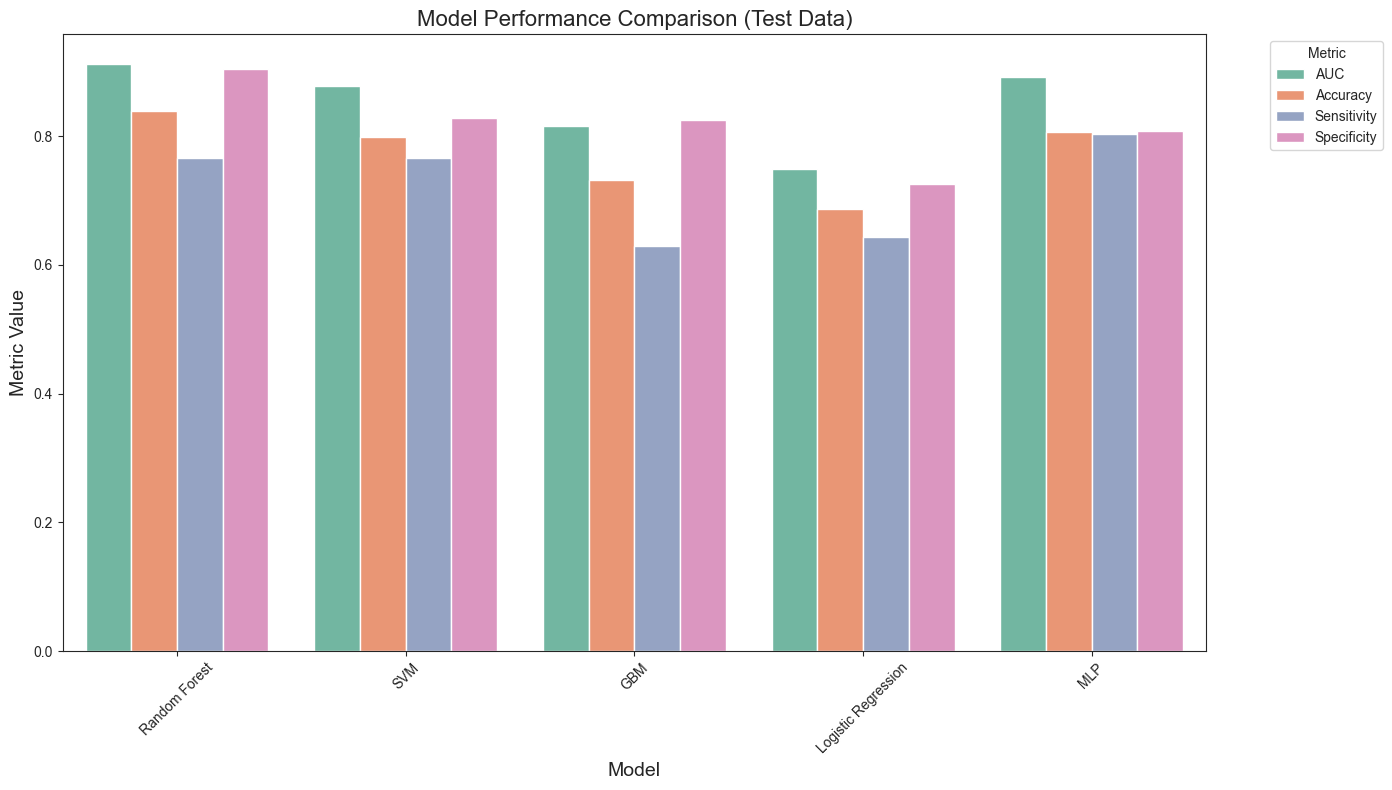

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
# Use Nature journal color palette
sns.set_palette("Set2")  # Nature journal style often aligns with "Set2" or similar palettes

# Plot all metrics for test data with Nature palette
plt.figure(figsize=(14, 8))
sns.barplot(
    data=test_metrics_melted, 
    x='Model', 
    y='Value', 
    hue='Metric', 
    ci=None
)
plt.title("Model Performance Comparison (Test Data)", fontsize=16)
plt.ylabel("Metric Value", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [77]:
auc_history.tail()

,epoch,Train Loss,Train AUC,Val Loss,Val AUC
995,996.0,0.553635,0.973288,0.617948,0.884267
996,997.0,0.553169,0.973255,0.619621,0.884447
997,998.0,0.554563,0.973305,0.616236,0.883408
998,999.0,0.554406,0.973172,0.620652,0.882434
999,1000.0,0.553850,0.973164,0.619483,0.883870


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

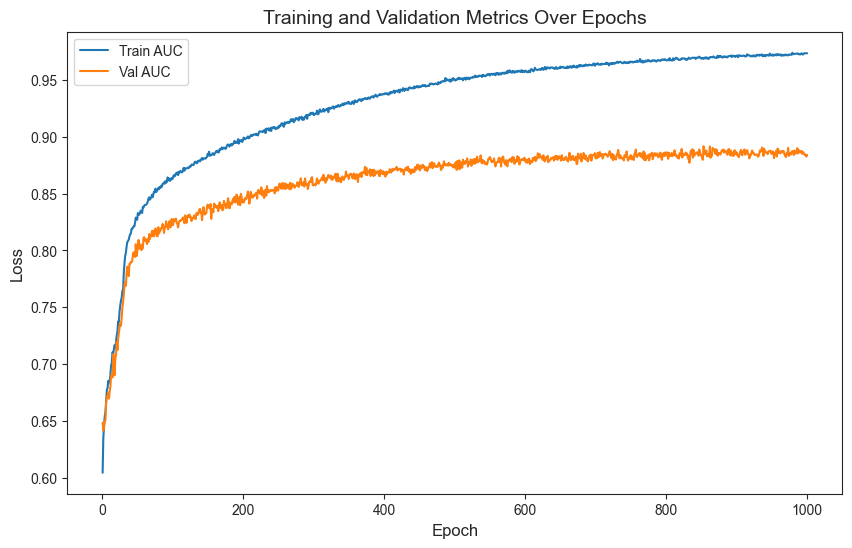

In [76]:
# Load metrics

metrics = auc_history
metrics[['epoch', 'Train Loss', 'Train AUC', 'Val Loss', 'Val AUC']] = metrics[['epoch', 'Train Loss', 'Train AUC', 'Val Loss', 'Val AUC']].astype(float)

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
sns.lineplot(data=metrics, x='epoch', y='Train AUC', label='Train AUC')
sns.lineplot(data=metrics, x='epoch', y='Val AUC', label='Val AUC')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_RMSE', label='Valid_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
# plt.xticks(ticks=np.arange(0, epochs+1, 500))  # Adjust step size as needed
# plt.xlim(-50, epochs+50)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()

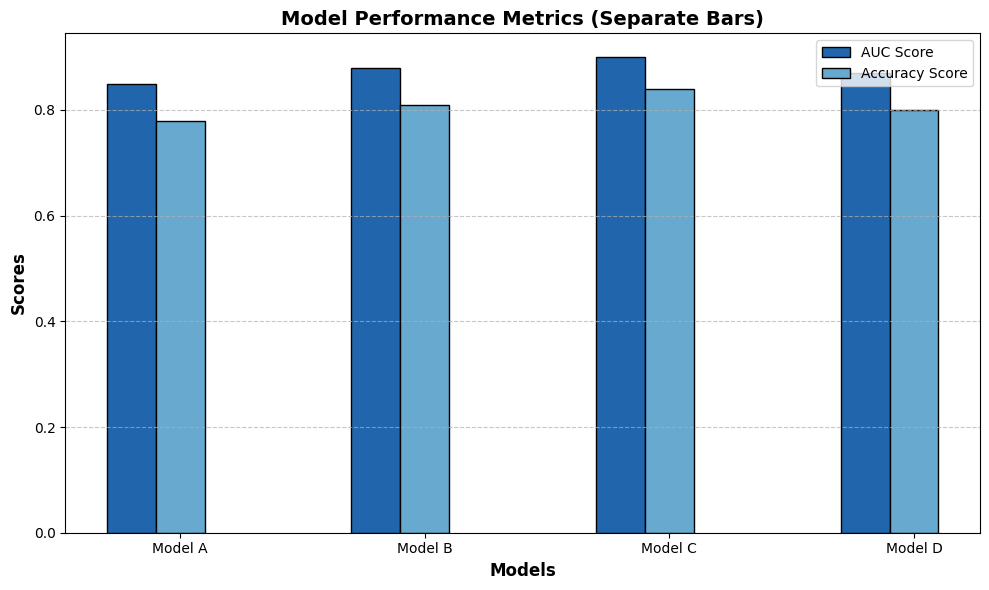

In [1]:
import matplotlib.pyplot as plt

# Example data for plotting
models = ['Model A', 'Model B', 'Model C', 'Model D']
auc_scores = [0.85, 0.88, 0.90, 0.87]
accuracy_scores = [0.78, 0.81, 0.84, 0.80]

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar width and positions
width = 0.2
x = range(len(models))

# Plot each score as a separate bar
bars_auc = ax.bar(
    [pos - width for pos in x], 
    auc_scores, 
    width, 
    label='AUC Score', 
    edgecolor='black', 
    color='#2166AC'  # Nature journal color palette
)

bars_accuracy = ax.bar(
    [pos for pos in x], 
    accuracy_scores, 
    width, 
    label='Accuracy Score', 
    edgecolor='black', 
    color='#67A9CF'  # Nature journal color palette
)

# Customization for Nature style
ax.set_xlabel('Models', fontsize=12, weight='bold')
ax.set_ylabel('Scores', fontsize=12, weight='bold')
ax.set_title('Model Performance Metrics (Separate Bars)', fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=10)
ax.legend(fontsize=10)

# Add grid and adjust style
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()
